In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List, Dict, Optional
import warnings
from collections import defaultdict
import matplotlib.pyplot as plt





In [2]:

with open("all_dataframes.pkl", "rb") as f:
    loaded_dfs = pickle.load(f)

# Access them like before:
data_df = loaded_dfs['data_df']
id_df = loaded_dfs['id_df']
train_df = loaded_dfs['train_df']
val_df = loaded_dfs['val_df']
test_df = loaded_dfs['test_df']
train_id_df = loaded_dfs['train_id_df']
val_id_df = loaded_dfs['val_id_df']
test_id_df = loaded_dfs['test_id_df']
data_df_high_energy = loaded_dfs['data_df_high_energy']
id_df_high_energy = loaded_dfs['id_df_high_energy']
val_df_high_energy = loaded_dfs['val_df_high_energy']
test_df_high_energy = loaded_dfs['test_df_high_energy']
val_id_df_high_energy = loaded_dfs['val_id_df_high_energy']
test_id_df_high_energy = loaded_dfs['test_id_df_high_energy']

In [3]:
def get_data_from_trajectory_id(ids_df, data_df, trajectory_ids):
    """
    Return the exact portion(s) of `data_df` corresponding to one or more trajectory_ids.
    - Preserves data_df's original indexing (no reset).
    - If trajectory_ids contains all ids in ids_df, returns data_df unchanged.
    - If any requested id is missing, prints missing ids and returns None.
    """
    # normalize to list of ints (preserve order)
    if isinstance(trajectory_ids, (np.integer, int)):
        trajectory_ids = [int(trajectory_ids)]
    else:
        trajectory_ids = [int(x) for x in trajectory_ids]

    # ensure id columns are ints in ids_df
    ids_df = ids_df.copy()
    for col in ("start_index", "end_index", "generated_points", "trajectory_id"):
        if col in ids_df.columns:
            ids_df[col] = ids_df[col].astype("int64")

    existing_ids = list(ids_df["trajectory_id"].values)
    missing = [tid for tid in trajectory_ids if tid not in existing_ids]
    if missing:
        print(f"trajectory_id(s) {missing} not in ids_df. Pick from {existing_ids}")
        return None

    # special-case: request for all trajectories -> return full data_df unchanged
    if set(trajectory_ids) == set(existing_ids):
        return data_df

    parts = []
    for tid in trajectory_ids:
        row = ids_df.loc[ids_df["trajectory_id"] == tid].iloc[0]
        start = int(row["start_index"])
        end = int(row["end_index"])   # exclusive by your convention

        if start >= end:
            # empty trajectory: skip (or you can append an empty frame if you prefer)
            continue

        # label-based selection: .loc is inclusive on the right, so use end-1
        sub = data_df.loc[start : end - 1]
        parts.append(sub)

    if not parts:
        # nothing found (all requested trajectories empty)
        return data_df.iloc[0:0]   # empty DataFrame with same columns

    # if single part, return it directly (preserves original index)
    if len(parts) == 1:
        return parts[0]
    # multiple parts: concatenate preserving indices and order
    return pd.concat(parts)

def get_trajectory_ids_by_energies(ids_df, want_more_energy, energy_percentile):
    if want_more_energy==False:
        return list(ids_df[ids_df['energy'] < ids_df['energy'].quantile(energy_percentile)]['trajectory_id'])
    if want_more_energy==True:
        return list(ids_df[ids_df['energy'] > ids_df['energy'].quantile(energy_percentile)]['trajectory_id'])
    

In [4]:
train_id_df

,trajectory_id,x0,u0,energy,generated_points,start_index,end_index
87,87,-1.706607,-13.080063,87.000281,242,21054,21296
22,22,-1.133508,-6.535809,22.000818,242,5324,5566
19,19,-1.529034,5.971913,19.000843,242,4598,4840
55,55,4.872181,9.287785,55.000545,242,13310,13552
15,15,1.731893,-5.196374,15.000876,242,3630,3872
...,...,...,...,...,...,...,...
36,36,3.726022,7.623527,36.000702,242,8712,8954
113,113,-5.883011,-13.834389,113.000066,242,27346,27588
34,34,-1.836646,-8.039165,34.000719,242,8228,8470
8,8,-0.755631,3.928217,8.000934,242,1936,2178


In [5]:
def sample_points_from_trejctory(trajectory_data, num_samples_overall, n_segments, random_segments=False):
    num_points = len(trajectory_data)
    if n_segments <= 0:
        raise ValueError("n_segments must be a positive integer.")
    if num_samples_overall == 0:
        return []
    
    num_samples_per_segment = num_samples_overall // n_segments
    if num_samples_per_segment == 0:
        print(f"Warning: With {num_points} points, {num_samples_overall} num_samples_overall, and {n_segments} segments, you'll get less than 1 sample per segment. Adjusting to sample 1 point from {num_samples_overall} segments.")
        num_samples_per_segment = 1
        n_segments = min(n_segments, num_samples_overall) # Adjust n_segments to actual samples
    segment_length = num_points // n_segments
    
    # Ensure we don't try to sample more points than available in a segment
    if num_samples_per_segment > segment_length:
        raise ValueError(f"num_samples_per_segment ({num_samples_per_segment}) is greater than "
                         f"the segment length ({segment_length}). Adjust sample_ratio or n_segments.")
    sampled_points = []
    
    if random_segments:
        for i in range(n_segments):
            # Define the bounds for choosing a center for this specific conceptual segment
            start_boundary = i * (num_points // n_segments)
            end_boundary = (i + 1) * (num_points // n_segments)
            
            # Adjust end_boundary for the last segment
            if i == n_segments - 1:
                end_boundary = num_points
            
            valid_min_start_index = start_boundary
            valid_max_start_index = end_boundary - num_samples_per_segment
            
            if valid_min_start_index > valid_max_start_index:
                # This segment is too small to fit the desired number of samples
                # print(f"Warning: Segment {i} cannot fit {num_samples_per_segment} samples. Skipping or taking what's available.")
                if end_boundary - start_boundary > 0:
                    # Take as many as possible if the segment has points
                    num_to_take = min(num_samples_per_segment, end_boundary - start_boundary)
                    start_idx = random.randint(start_boundary, end_boundary - num_to_take)
                    sampled_points.extend(trajectory_data[start_idx : start_idx + num_to_take])
                continue # Skip to next segment
            random_start_index = random.randint(valid_min_start_index, valid_max_start_index)
            
            # Add points to the list
            sampled_points.extend(trajectory_data[random_start_index : random_start_index + num_samples_per_segment])
        return sampled_points
    else: # Equally separated segments
        step_between_segments = num_points // n_segments
        
        # Calculate the effective sample size to prevent index errors
        # if num_samples_per_segment is large relative to step_between_segments
        effective_sample_size = min(num_samples_per_segment, step_between_segments)
        for i in range(n_segments):
            segment_start_index = i * step_between_segments
            
            # Ensure we don't go out of bounds when taking consecutive points
            # The end index should not exceed num_points
            end_index_for_segment = min(segment_start_index + effective_sample_size, num_points)
            
            # If a segment is empty due to rounding, skip
            if segment_start_index >= end_index_for_segment:
                continue
            sampled_points.extend(trajectory_data[segment_start_index : end_index_for_segment])
        return sampled_points


In [6]:
class HarmonicOscillatorDataset(Dataset):
    """
    Custom Dataset for harmonic oscillator trajectories with specific batch sampling strategy.
    """
    
    def __init__(
        self,
        train_df: pd.DataFrame,
        train_id_df: pd.DataFrame,
        m: int,
        points_per_trajectory_number_of_different_trajectories_ratio: float,
        segment_length: int,  # w: consecutive points per segment
        get_data_func=None,  # Your get_data_from_trajectory_id function
        seed: Optional[int] = None
    ):
        """
        Args:
            train_df: DataFrame with columns 'x', 'u', 't' containing all trajectories
            train_id_df: DataFrame with trajectory metadata including 'energy', 'start_index', 'end_index'
            m: Hyperparameter to calculate batch_size = 2 * m^2
            points_per_trajectory_number_of_different_trajectories_ratio: T/K ratio
            segment_length: Number of consecutive points per segment (w)
            get_data_func: Function to extract trajectory data
            seed: Random seed for reproducibility
        """
        self.train_df = train_df
        self.train_id_df = train_id_df.copy()
        self.m = m
        self.ratio = points_per_trajectory_number_of_different_trajectories_ratio
        self.segment_length = segment_length
        self.get_data_func = get_data_func
        
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        # Calculate batch parameters
        self.batch_size = 2 * np.square(m)
        self.points_per_trajectory = round(np.sqrt(self.ratio * self.batch_size))
        self.number_of_trajectories = round(self.points_per_trajectory / self.ratio)
        
        # Calculate number of segments per trajectory
        self.segments_per_trajectory = self.points_per_trajectory // self.segment_length
        if self.segments_per_trajectory * self.segment_length != self.points_per_trajectory:
            warnings.warn(
                f"points_per_trajectory ({self.points_per_trajectory}) is not divisible by "
                f"segment_length ({self.segment_length}). Using {self.segments_per_trajectory} "
                f"segments with {self.segments_per_trajectory * self.segment_length} points."
            )
            self.points_per_trajectory = self.segments_per_trajectory * self.segment_length
        
        # Actual batch size after adjustments
        self.actual_batch_size = self.number_of_trajectories * self.points_per_trajectory
        
        # Pre-compute valid trajectories and their available segments
        self._prepare_trajectory_segments()
        
        # Generate epoch sampling plan
        self._generate_epoch_plan()
        
        print(f"Dataset initialized:")
        print(f"  Batch size (nominal): {self.batch_size}")
        print(f"  Actual batch size: {self.actual_batch_size}")
        print(f"  Number of trajectories per batch (K): {self.number_of_trajectories}")
        print(f"  Points per trajectory (T): {self.points_per_trajectory}")
        print(f"  Segments per trajectory (S): {self.segments_per_trajectory}")
        print(f"  Segment length (w): {self.segment_length}")
        print(f"  Number of batches: {len(self)}")
    
    def _prepare_trajectory_segments(self):
        """Pre-compute which segments are available in each trajectory."""
        self.trajectory_segments = {}
        
        for _, row in self.train_id_df.iterrows():
            tid = row['trajectory_id']
            start_idx = row['start_index']
            end_idx = row['end_index']
            traj_length = int(end_idx - start_idx)
            
            # Number of possible segment starting positions
            if traj_length >= self.segment_length:
                num_possible_segments = traj_length - self.segment_length + 1
                self.trajectory_segments[tid] = {
                    'energy': row['energy'],
                    'start_index': start_idx,
                    'end_index': end_idx,
                    'length': traj_length,
                    'possible_segments': num_possible_segments,
                    'segment_starts': list(range(num_possible_segments))
                }
    
    def _generate_epoch_plan(self):
        """Generate the sampling plan for the entire epoch ensuring no overlap."""
        self.epoch_batches = []
        
        # Track used segments for each trajectory
        used_segments = {tid: set() for tid in self.trajectory_segments.keys()}
        
        # Continue until we can't form complete batches
        while True:
            # Find trajectories with enough unused segments
            available_trajectories = []
            for tid, info in self.trajectory_segments.items():
                unused_count = len(info['segment_starts']) - len(used_segments[tid])
                if unused_count >= self.segments_per_trajectory:
                    available_trajectories.append(tid)
            
            # Check if we can form a complete batch
            if len(available_trajectories) < self.number_of_trajectories:
                break
            
            # Select trajectories with maximum energy diversity
            selected_tids = self._select_diverse_trajectories(
                available_trajectories, 
                self.number_of_trajectories
            )
            
            # For each selected trajectory, sample segments
            batch_data = []
            for tid in selected_tids:
                # Get unused segment starts for this trajectory
                all_starts = set(self.trajectory_segments[tid]['segment_starts'])
                unused_starts = all_starts - used_segments[tid]
                unused_starts = list(unused_starts)
                
                # Sample non-overlapping segments
                selected_starts = self._sample_non_overlapping_segments(
                    unused_starts,
                    self.segments_per_trajectory,
                    self.segment_length
                )
                
                # Mark segments as used
                for start in selected_starts:
                    for i in range(self.segment_length):
                        used_segments[tid].add(start + i)
                
                # Store batch info
                batch_data.append({
                    'trajectory_id': tid,
                    'segment_starts': selected_starts
                })
            
            self.epoch_batches.append(batch_data)
    
    def _select_diverse_trajectories(self, trajectory_ids: List[int], k: int) -> List[int]:
        """Select k trajectories with maximum energy diversity."""
        if len(trajectory_ids) <= k:
            return trajectory_ids
        
        # Get energies
        energies = [self.trajectory_segments[tid]['energy'] for tid in trajectory_ids]
        
        # Sort trajectories by energy
        sorted_indices = np.argsort(energies)
        sorted_tids = [trajectory_ids[i] for i in sorted_indices]
        
        # Select evenly spaced trajectories for maximum diversity
        if k == 1:
            return [sorted_tids[len(sorted_tids) // 2]]  # median energy
        
        indices = np.linspace(0, len(sorted_tids) - 1, k, dtype=int)
        selected = [sorted_tids[i] for i in indices]
        
        return selected
    
    def _sample_non_overlapping_segments(
        self, 
        available_starts: List[int], 
        num_segments: int,
        segment_length: int
    ) -> List[int]:
        """Sample non-overlapping segments from available starting positions."""
        selected = []
        available = set(available_starts)
        
        for _ in range(num_segments):
            if not available:
                break
            
            # Choose a random start
            start = np.random.choice(list(available))
            selected.append(start)
            
            # Remove overlapping positions
            for i in range(max(0, start - segment_length + 1), 
                          min(start + segment_length, max(available) + 1)):
                available.discard(i)
        
        return sorted(selected)
    
    def __len__(self):
        return len(self.epoch_batches)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Get a batch of data.
        
        Returns:
            Dictionary with:
                - 'x': position tensor of shape (batch_size,)
                - 'u': velocity tensor of shape (batch_size,)
                - 't': time tensor of shape (batch_size,)
                - 'trajectory_ids': tensor of trajectory IDs for each point
                - 'energies': tensor of energies for each point
        """
        batch_info = self.epoch_batches[idx]
        
        x_list, u_list, t_list = [], [], []
        tid_list, energy_list = [], []
        
        for traj_info in batch_info:
            tid = int(traj_info['trajectory_id'])
            segment_starts = traj_info['segment_starts']
            
            # Get trajectory data
            if self.get_data_func:
                traj_data = self.get_data_func(self.train_id_df, self.train_df, tid)
            else:
                # Fallback: direct indexing
                start_idx = self.trajectory_segments[tid]['start_index']
                end_idx = self.trajectory_segments[tid]['end_index']
                traj_data = self.train_df.loc[start_idx:end_idx-1]
            
            # Reset index to use relative positions
            traj_data = traj_data.reset_index(drop=True)
            
            # Extract segments
            for seg_start in segment_starts:
                for offset in range(self.segment_length):
                    idx_in_traj = seg_start + offset
                    x_list.append(traj_data.loc[idx_in_traj, 'x'])
                    u_list.append(traj_data.loc[idx_in_traj, 'u'])
                    t_list.append(traj_data.loc[idx_in_traj, 't'])
                    tid_list.append(tid)
                    energy_list.append(self.trajectory_segments[tid]['energy'])
        
        return {
            'x': torch.tensor(x_list, dtype=torch.float32),
            'u': torch.tensor(u_list, dtype=torch.float32),
            't': torch.tensor(t_list, dtype=torch.float32),
            'trajectory_ids': torch.tensor(tid_list, dtype=torch.long),
            'energies': torch.tensor(energy_list, dtype=torch.float32)
        }
    
    def regenerate_epoch(self, seed: Optional[int] = None):
        """Regenerate the epoch sampling plan with a new random seed."""
        if seed is not None:
            np.random.seed(seed)
        self._generate_epoch_plan()


def create_dataloader(
    train_df: pd.DataFrame,
    train_id_df: pd.DataFrame,
    m: int,
    points_per_trajectory_number_of_different_trajectories_ratio: float,
    segment_length: int,
    get_data_func=None,
    num_workers: int = 0,
    pin_memory: bool = True,
    seed: Optional[int] = None
) -> DataLoader:
    """
    Create a DataLoader with the custom sampling strategy.
    
    Args:
        train_df: DataFrame with trajectory data
        train_id_df: DataFrame with trajectory metadata
        m: Hyperparameter for batch size calculation
        points_per_trajectory_number_of_different_trajectories_ratio: T/K ratio
        segment_length: Number of consecutive points per segment (w)
        get_data_func: Function to extract trajectory data
        num_workers: Number of worker processes for data loading
        pin_memory: Whether to pin memory for CUDA
        seed: Random seed for reproducibility
    
    Returns:
        DataLoader configured with the custom dataset
    """
    dataset = HarmonicOscillatorDataset(
        train_df=train_df,
        train_id_df=train_id_df,
        m=m,
        points_per_trajectory_number_of_different_trajectories_ratio=points_per_trajectory_number_of_different_trajectories_ratio,
        segment_length=segment_length,
        get_data_func=get_data_func,
        seed=seed
    )
    
    # Create DataLoader with batch_size=1 since our dataset already returns batches
    dataloader = DataLoader(
        dataset,
        batch_size=1,  # Dataset handles batching internally
        shuffle=False,  # Shuffling is handled in epoch generation
        num_workers=num_workers,
        pin_memory=pin_memory,
        collate_fn=lambda x: x[0]  # Return the batch directly
    )
    
    return dataloader





In [7]:
points_per_trajectory_number_of_different_trajectories_ratio = 2
m=20
points_per_segment = 4

if __name__ == "__main__":
    dataloader = create_dataloader(
        train_df=train_df,
        train_id_df=train_id_df,
        m=m,  # batch_size = 2 * m^2 
        points_per_trajectory_number_of_different_trajectories_ratio=points_per_trajectory_number_of_different_trajectories_ratio,  
        segment_length=points_per_segment,  # consecutive points per segment
        get_data_func=get_data_from_trajectory_id,
        seed=42
    )

Dataset initialized:
  Batch size (nominal): 800
  Actual batch size: 800
  Number of trajectories per batch (K): 20
  Points per trajectory (T): 40
  Segments per trajectory (S): 10
  Segment length (w): 4
  Number of batches: 40


In [65]:
def diff_with_previous(nums):
    if not nums:
        return []
    return [nums[0]] + [nums[i] - nums[i-1] for i in range(1, len(nums))]

In [66]:
from collections import Counter

def analyze_gaps(nums):
    # 1) Find smallest number > 1
    greater_than_one = [n for n in nums if n > 1]
    if not greater_than_one:
        return None, False, False  # no valid numbers
    smallest = min(greater_than_one)
    
    # 2) Check divisibility
    divisible = all(n % smallest == 0 for n in greater_than_one)
    
    # 3) Check if it's the most common number
    freq = Counter(nums)
    most_common_num, most_common_count = freq.most_common(1)[0]
    is_most_common = (smallest == most_common_num)
    
    return smallest, divisible, is_most_common




DATALOADER VALIDATION

Expected Parameters:
  - Batch size: 800
  - Trajectories per batch (K): 20
  - Points per trajectory (T): 40
  - Segments per trajectory (S): 10
  - Segment length (w): 4
  - Total batches: 40
  - Total trajectories in dataset: 96


Validating Batch 1/40...
  First few x values: [0.03130980208516121, 0.034476157277822495, 0.037264786660671234, 0.039645131677389145, 0.03774455189704895]
  First few t values: [1.4660766124725342, 1.5707963705062866, 1.675516128540039, 1.7802358865737915, 2.8274333477020264]
  Unique trajectories in batch: [0, 5, 14, 19, 24, 30, 36, 44, 49, 56, 62, 69, 76, 82, 89, 96, 102, 108, 113, 120]

EPOCH-LEVEL VALIDATION

VALIDATION SUMMARY
✓ Passed tests: 10
✗ Failed tests: 29
⚠ Warnings: 1

Passed Test Types (10):
  ✓ Correct points per trajectory
  ✓ Correct number of segments per trajectory
  ✓ Consistent time steps within segments
  ✓ Data values match original DataFrame
  ✓ Segments have correct length
  ✓ Correct number of trajectorie

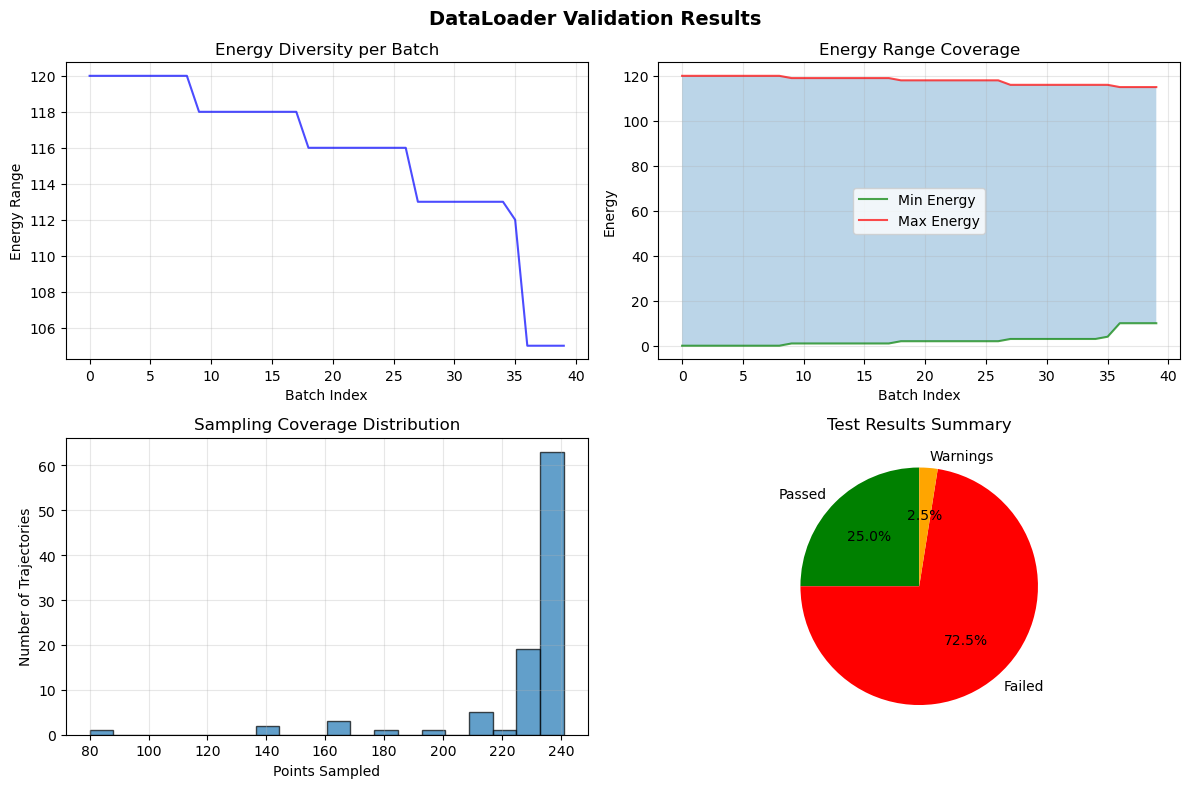

In [67]:

def validate_dataloader_fixed(
    dataloader,
    train_df: pd.DataFrame,
    train_id_df: pd.DataFrame,
    get_data_func,
    verbose: bool = True,
    plot_results: bool = True
) -> Dict[str, Any]:
    """
    Comprehensive validation of the harmonic oscillator dataloader with floating-point tolerance.
    
    Args:
        dataloader: The DataLoader to validate
        train_df: Original training DataFrame
        train_id_df: Trajectory metadata DataFrame
        get_data_func: Function to extract trajectory data
        verbose: Whether to print detailed information
        plot_results: Whether to plot validation results
    
    Returns:
        Dictionary with validation results and statistics
    """
    
    results = {
        'passed_tests': [],
        'failed_tests': [],
        'warnings': [],
        'statistics': {},
        'detailed_info': {}
    }
    
    # Get dataset parameters
    dataset = dataloader.dataset
    expected_batch_size = dataset.actual_batch_size
    expected_trajectories_per_batch = dataset.number_of_trajectories
    expected_points_per_trajectory = dataset.points_per_trajectory
    segment_length = dataset.segment_length
    segments_per_trajectory = dataset.segments_per_trajectory
    
    if verbose:
        print("="*80)
        print("DATALOADER VALIDATION")
        print("="*80)
        print(f"\nExpected Parameters:")
        print(f"  - Batch size: {expected_batch_size}")
        print(f"  - Trajectories per batch (K): {expected_trajectories_per_batch}")
        print(f"  - Points per trajectory (T): {expected_points_per_trajectory}")
        print(f"  - Segments per trajectory (S): {segments_per_trajectory}")
        print(f"  - Segment length (w): {segment_length}")
        print(f"  - Total batches: {len(dataloader)}")
        print(f"  - Total trajectories in dataset: {len(train_id_df)}")
        print("\n" + "="*80)
    
    # Track all sampled points across the epoch
    epoch_points_tracker = defaultdict(set)  # {trajectory_id: set of (relative_index)}
    batch_statistics = []
    
    # Helper function to find index with floating-point tolerance
    def find_time_index(traj_data, t_value, rtol=1e-3, atol=1e-3):
        """Find index of time value with floating-point tolerance."""
        matches = traj_data[np.isclose(traj_data['t'], t_value, rtol=rtol, atol=atol)]
        if len(matches) == 0:
            return None
        return matches.index[0]
    
    # Iterate through all batches
    for batch_idx, batch in enumerate(dataloader):
        if verbose and batch_idx == 0:
            print(f"\nValidating Batch {batch_idx + 1}/{len(dataloader)}...")
            print(f"  First few x values: {batch['x'][:5].tolist()}")
            print(f"  First few t values: {batch['t'][:5].tolist()}")
            print(f"  Unique trajectories in batch: {torch.unique(batch['trajectory_ids']).tolist()}")
        
        # TEST 1: Check batch has same number of x, u, t values
        test_name = f"Batch {batch_idx}: Consistent x, u, t dimensions"
        try:
            assert len(batch['x']) == len(batch['u']) == len(batch['t']), \
                f"Inconsistent dimensions: x={len(batch['x'])}, u={len(batch['u'])}, t={len(batch['t'])}"
            if batch_idx == 0:
                results['passed_tests'].append("Consistent x, u, t dimensions")
        except AssertionError as e:
            results['failed_tests'].append(f"{test_name}: {str(e)}")
        
        # TEST 2: Check batch size
        test_name = f"Batch {batch_idx}: Correct batch size"
        actual_size = len(batch['x'])
        try:
            assert actual_size == expected_batch_size, \
                f"Expected {expected_batch_size}, got {actual_size}"
            if batch_idx == 0:
                results['passed_tests'].append("Correct batch size")
        except AssertionError as e:
            results['failed_tests'].append(f"{test_name}: {str(e)}")
        
        # Group points by trajectory
        trajectory_groups = defaultdict(list)
        for i in range(len(batch['x'])):
            tid = batch['trajectory_ids'][i].item()
            trajectory_groups[tid].append({
                'index': i,
                'x': batch['x'][i].item(),
                'u': batch['u'][i].item(),
                't': batch['t'][i].item(),
                'energy': batch['energies'][i].item()
            })
        
        # TEST 3: Check number of trajectories in batch
        test_name = f"Batch {batch_idx}: Correct number of trajectories"
        try:
            assert len(trajectory_groups) == expected_trajectories_per_batch, \
                f"Expected {expected_trajectories_per_batch} trajectories, got {len(trajectory_groups)}"
            if batch_idx == 0:
                results['passed_tests'].append("Correct number of trajectories per batch")
        except AssertionError as e:
            results['failed_tests'].append(f"{test_name}: {str(e)}")
        
        # TEST 4: Check points per trajectory
        test_name = f"Batch {batch_idx}: Correct points per trajectory"
        points_per_traj_ok = True
        for tid, points in trajectory_groups.items():
            try:
                assert len(points) == expected_points_per_trajectory, \
                    f"Trajectory {tid}: Expected {expected_points_per_trajectory} points, got {len(points)}"
            except AssertionError as e:
                results['failed_tests'].append(f"{test_name}: {str(e)}")
                points_per_traj_ok = False
                break
        if points_per_traj_ok and batch_idx == 0:
            results['passed_tests'].append("Correct points per trajectory")
        
        if len(train_df) > 1:
            expected_dt = train_df.iloc[1]['t'] - train_df.iloc[0]['t']
        else:
            expected_dt = 0.1  # fallback value
        
        # For each trajectory in the batch
        for tid, points in trajectory_groups.items():
            # Get original trajectory data
            traj_data = get_data_func(train_id_df, train_df, tid)

            


            
            # Derive the actual points per segment by analyzing time differences
            consecutive_count = 1
            derived_points_per_segment = 1
            
            
            gap_positions = []
            for i in range(1, len(points)):  
                dt = points[i]['t'] - points[i-1]['t']
                if not np.isclose(dt, expected_dt, rtol=1e-3):  # Consecutive
                    gap_positions.append(i)
            possible_derived_points_per_segment_list = diff_with_previous(gap_positions)
            smallest, divisible, is_most_common = analyze_gaps(possible_derived_points_per_segment_list)
            
            derived_points_per_segment = gap_positions[0]
            if (smallest is not None) and (divisible) and (is_most_common):
                derived_points_per_segment=smallest

            
            # Now identify segments based on the derived segment length
            segments = []
            i = 0
            while i < len(points):
                segment = [points[i]]
                j = i + 1
                
                # Collect points that are consecutive (based on dt)
                while j < len(points) and len(segment) < derived_points_per_segment:
                    dt = points[j]['t'] - points[j-1]['t']
                    if np.isclose(dt, expected_dt, rtol=1e-3):
                        segment.append(points[j])
                        j += 1
                    else:
                        break  # Gap found, end this segment
                
                segments.append(segment)
                i = j  # Move to next potential segment start
            
            # Calculate derived number of segments
            derived_segments_per_trajectory = len([s for s in segments if len(s) == derived_points_per_segment])
            
            # TEST 5: Check segment structure consistency
            test_name = f"Batch {batch_idx}, Trajectory {tid}: Segment structure"
            
            # First check if derived matches expected
            if batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                if derived_points_per_segment != segment_length:
                    results['warnings'].append(
                        f"Segment length mismatch: expected {segment_length}, derived {derived_points_per_segment}"
                    )
                    if verbose:
                        print(f"  WARNING: Derived segment length ({derived_points_per_segment}) != expected ({segment_length})")
            
            # Check if number of complete segments matches expected
            #expected_segments_from_derived = len(points) // derived_points_per_segment
            try:
                assert derived_segments_per_trajectory == segments_per_trajectory, \
                    f"Expected {segments_per_trajectory} segments, got {derived_segments_per_trajectory} complete segments of length {derived_points_per_segment}"
                if batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                    results['passed_tests'].append("Correct number of segments per trajectory")
            except AssertionError as e:
                results['failed_tests'].append(f"{test_name}: {str(e)}")
            
            # TEST 6: Check segment lengths and consecutiveness
            for seg_idx, segment in enumerate(segments):
                test_name = f"Batch {batch_idx}, Trajectory {tid}, Segment {seg_idx}: Correct length"
                try:
                    assert len(segment) == segment_length, \
                        f"Expected length {segment_length}, got {len(segment)}"
                    if batch_idx == 0 and tid == list(trajectory_groups.keys())[0] and seg_idx == 0:
                        results['passed_tests'].append("Segments have correct length")
                except AssertionError as e:
                    results['failed_tests'].append(f"{test_name}: {str(e)}")
                
            # TEST 7: Check dt consistency within each segment
            test_name = f"Batch {batch_idx}, Trajectory {tid}: Time consistency within segments"
            dt_consistent = True
            for seg_idx, segment in enumerate(segments):
                if len(segment) > 1:
                    for i in range(1, len(segment)):
                        dt = segment[i]['t'] - segment[i-1]['t']
                        if not np.isclose(dt, expected_dt, rtol=1e-3):
                            dt_consistent = False
                            if batch_idx == 0 and tid == list(trajectory_groups.keys())[0] and seg_idx < 3:
                                results['warnings'].append(
                                    f"Segment {seg_idx}: inconsistent dt at position {i}: {dt:.6f} (expected {expected_dt:.6f})"
                                )
            
            if dt_consistent and batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                results['passed_tests'].append("Consistent time steps within segments")
            
            # TEST 8: Check no overlap between segments within trajectory
            test_name = f"Batch {batch_idx}, Trajectory {tid}: No segment overlap"
            segment_indices = []
            for segment in segments:
                indices = []
                for point in segment:
                    idx = find_time_index(traj_data, point['t'])
                    if idx is not None:
                        indices.append(idx)
                if indices:  # Only add if we found valid indices
                    segment_indices.append(set(indices))
            
            overlap_found = False
            for i in range(len(segment_indices)):
                for j in range(i+1, len(segment_indices)):
                    if segment_indices[i] & segment_indices[j]:  # intersection
                        overlap_found = True
                        results['failed_tests'].append(
                            f"{test_name}: Segments {i} and {j} overlap"
                        )
                        break
                if overlap_found:
                    break
            
            if not overlap_found and batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                results['passed_tests'].append("No segment overlap within trajectories")
            
            # TEST 9: Check data correctness
            test_name = f"Batch {batch_idx}, Trajectory {tid}: Data correctness"
            data_correct = True
            for point_idx, point in enumerate(points[:5]):  # Check first 5 points per trajectory
                t_val = point['t']
                try:
                    idx = find_time_index(traj_data, t_val)
                    if idx is None:
                        raise IndexError(f"Time value {t_val} not found in trajectory")
                    orig_row = traj_data.loc[idx]
                    
                    assert np.isclose(point['x'], orig_row['x'], rtol=1e-6), \
                        f"x mismatch: {point['x']} != {orig_row['x']}"
                    assert np.isclose(point['u'], orig_row['u'], rtol=1e-6), \
                        f"u mismatch: {point['u']} != {orig_row['u']}"
                    
                except (AssertionError, IndexError) as e:
                    results['failed_tests'].append(f"{test_name}: {str(e)}")
                    data_correct = False
                    break
            
            if data_correct and batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                results['passed_tests'].append("Data values match original DataFrame")
            
            # Track points for epoch coverage test
            for point in points:
                idx = find_time_index(traj_data, point['t'])
                if idx is not None:
                    epoch_points_tracker[tid].add(idx)
        
        # TEST 10: Check energy diversity in batch
        energies = [trajectory_groups[tid][0]['energy'] for tid in trajectory_groups.keys()]
        energy_std = np.std(energies)
        energy_range = max(energies) - min(energies)
        
        batch_statistics.append({
            'batch_idx': batch_idx,
            'num_trajectories': len(trajectory_groups),
            'batch_size': actual_size,
            'energy_std': energy_std,
            'energy_range': energy_range,
            'min_energy': min(energies),
            'max_energy': max(energies)
        })
    
    # TEST 11: Check epoch coverage - every point sampled exactly once
    if verbose:
        print("\n" + "="*80)
        print("EPOCH-LEVEL VALIDATION")
        print("="*80)
    
    test_name = "Epoch coverage: Every point sampled exactly once"
    coverage_issues = []
    
    for _, row in train_id_df.iterrows():
        tid = row['trajectory_id']
        start_idx = int(row['start_index'])
        end_idx = int(row['end_index'])
        expected_indices = set(range(end_idx - start_idx))
        
        if tid in epoch_points_tracker:
            sampled_indices = epoch_points_tracker[tid]
            
            # Check for missing points
            missing = expected_indices - sampled_indices
            if missing:
                coverage_issues.append(f"Trajectory {tid}: {len(missing)} points not sampled")
            
        else:
            if end_idx > start_idx:  # Only if trajectory has points
                coverage_issues.append(f"Trajectory {tid}: Not sampled at all")
    
    if coverage_issues:
        results['failed_tests'].append(f"{test_name}: {coverage_issues[:5]}")  # Show first 5 issues
        if len(coverage_issues) > 5:
            results['warnings'].append(f"... and {len(coverage_issues)-5} more coverage issues")
    else:
        results['passed_tests'].append(test_name)
    
    # TEST 12: No data point appears twice in epoch
    test_name = "No duplicate sampling in epoch"
    all_points_in_epoch = []
    for batch in dataloader:
        for i in range(len(batch['x'])):
            # Round time values to avoid floating-point issues
            t_rounded = round(batch['t'][i].item(), 10)
            all_points_in_epoch.append((
                batch['trajectory_ids'][i].item(),
                t_rounded
            ))
    
    if len(all_points_in_epoch) != len(set(all_points_in_epoch)):
        duplicates = len(all_points_in_epoch) - len(set(all_points_in_epoch))
        results['failed_tests'].append(f"{test_name}: {duplicates} duplicate points found")
    else:
        results['passed_tests'].append(test_name)
    
    # Calculate statistics
    results['statistics'] = {
        'total_batches': len(dataloader),
        'total_points_in_epoch': len(all_points_in_epoch),
        'unique_points_in_epoch': len(set(all_points_in_epoch)),
        'trajectories_sampled': len(epoch_points_tracker),
        'avg_energy_std_per_batch': np.mean([b['energy_std'] for b in batch_statistics]) if batch_statistics else 0,
        'avg_energy_range_per_batch': np.mean([b['energy_range'] for b in batch_statistics]) if batch_statistics else 0,
    }
    
    # Additional sanity checks
    test_name = "Total points matches expected"
    total_points_original = sum(row['end_index'] - row['start_index'] 
                               for _, row in train_id_df.iterrows())
    if results['statistics']['unique_points_in_epoch'] <= total_points_original:
        results['passed_tests'].append(test_name)
    else:
        results['failed_tests'].append(
            f"{test_name}: Sampled {results['statistics']['unique_points_in_epoch']} "
            f"but only {total_points_original} points exist"
        )
    
    # Print summary
    if verbose:
        print(f"\n{'='*80}")
        print("VALIDATION SUMMARY")
        print(f"{'='*80}")
        print(f"✓ Passed tests: {len(results['passed_tests'])}")
        print(f"✗ Failed tests: {len(results['failed_tests'])}")
        print(f"⚠ Warnings: {len(results['warnings'])}")
        
        # Show unique passed tests (not duplicates from each batch)
        unique_passed = list(set(results['passed_tests']))
        print(f"\nPassed Test Types ({len(unique_passed)}):")
        for test in unique_passed:
            print(f"  ✓ {test}")
        
        if results['failed_tests']:
            print("\nFailed Tests:")
            for test in results['failed_tests'][:10]:  # Show first 10
                print(f"  ✗ {test}")
            if len(results['failed_tests']) > 10:
                print(f"  ... and {len(results['failed_tests'])-10} more")
        
        if results['warnings']:
            print("\nWarnings:")
            for warning in results['warnings'][:5]:
                print(f"  ⚠ {warning}")
            if len(results['warnings']) > 5:
                print(f"  ... and {len(results['warnings'])-5} more")
        
        print(f"\nStatistics:")
        for key, value in results['statistics'].items():
            print(f"  - {key}: {value:.4f}" if isinstance(value, float) else f"  - {key}: {value}")
    
    # Plot results
    if plot_results and batch_statistics:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle('DataLoader Validation Results', fontsize=14, fontweight='bold')
        
        # Energy diversity across batches
        ax = axes[0, 0]
        batch_indices = [b['batch_idx'] for b in batch_statistics]
        energy_ranges = [b['energy_range'] for b in batch_statistics]
        ax.plot(batch_indices, energy_ranges, 'b-', alpha=0.7)
        ax.set_xlabel('Batch Index')
        ax.set_ylabel('Energy Range')
        ax.set_title('Energy Diversity per Batch')
        ax.grid(True, alpha=0.3)
        
        # Energy distribution
        ax = axes[0, 1]
        min_energies = [b['min_energy'] for b in batch_statistics]
        max_energies = [b['max_energy'] for b in batch_statistics]
        ax.fill_between(batch_indices, min_energies, max_energies, alpha=0.3)
        ax.plot(batch_indices, min_energies, 'g-', label='Min Energy', alpha=0.7)
        ax.plot(batch_indices, max_energies, 'r-', label='Max Energy', alpha=0.7)
        ax.set_xlabel('Batch Index')
        ax.set_ylabel('Energy')
        ax.set_title('Energy Range Coverage')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Coverage histogram
        ax = axes[1, 0]
        coverage_per_trajectory = [len(indices) for indices in epoch_points_tracker.values()]
        if coverage_per_trajectory:
            ax.hist(coverage_per_trajectory, bins=20, edgecolor='black', alpha=0.7)
            ax.set_xlabel('Points Sampled')
            ax.set_ylabel('Number of Trajectories')
            ax.set_title('Sampling Coverage Distribution')
            ax.grid(True, alpha=0.3)
        
        # Test results pie chart
        ax = axes[1, 1]
        test_counts = [len(set(results['passed_tests'])),  # Count unique passed tests
                      len(results['failed_tests']), 
                      len(results['warnings'])]
        labels = ['Passed', 'Failed', 'Warnings']
        colors = ['green', 'red', 'orange']
        if sum(test_counts) > 0:
            wedges, texts, autotexts = ax.pie(test_counts, labels=labels, colors=colors, 
                                               autopct=lambda pct: f'{pct:.1f}%' if pct > 0 else '',
                                               startangle=90)
            ax.set_title('Test Results Summary')
        
        plt.tight_layout()
        plt.show()
    
    return results


# Use this function directly instead of the one with the error
results = validate_dataloader_fixed(
    dataloader=dataloader,
    train_df=train_df,
    train_id_df=train_id_df,
    get_data_func=get_data_from_trajectory_id,
    verbose=True,
    plot_results=True
)

In [68]:
results['failed_tests']

['Batch 9: Correct batch size: Expected 800, got 796',
 'Batch 9: Correct points per trajectory: Trajectory 56: Expected 40 points, got 36',
 'Batch 9, Trajectory 56: Segment structure: Expected 10 segments, got 9 complete segments of length 4',
 'Batch 19: Correct batch size: Expected 800, got 796',
 'Batch 19: Correct points per trajectory: Trajectory 74: Expected 40 points, got 36',
 'Batch 19, Trajectory 74: Segment structure: Expected 10 segments, got 9 complete segments of length 4',
 'Batch 20: Correct batch size: Expected 800, got 796',
 'Batch 20: Correct points per trajectory: Trajectory 87: Expected 40 points, got 36',
 'Batch 20, Trajectory 87: Segment structure: Expected 10 segments, got 9 complete segments of length 4',
 'Batch 22: Correct batch size: Expected 800, got 796',
 'Batch 22: Correct points per trajectory: Trajectory 100: Expected 40 points, got 36',
 'Batch 22, Trajectory 100: Segment structure: Expected 10 segments, got 9 complete segments of length 4',
 'Bat

In [10]:
for i, batch in enumerate(dataloader):
    if i==2:
        break

In [11]:
trajectory_groups = defaultdict(list)
for i in range(len(batch['x'])):
    tid = batch['trajectory_ids'][i].item()
    trajectory_groups[tid].append({
        'index': i,
        'x': batch['x'][i].item(),
        'u': batch['u'][i].item(),
        't': batch['t'][i].item(),
        'energy': batch['energies'][i].item()
    })

In [58]:
trajectory_groups[0]

[{'index': 0,
  'x': -0.04308142513036728,
  'u': -0.011999615468084812,
  't': 5.13126802444458,
  'energy': 0.0010000000474974513},
 {'index': 1,
  'x': -0.04409972205758095,
  'u': -0.007430645637214184,
  't': 5.235987663269043,
  'energy': 0.0010000000474974513},
 {'index': 2,
  'x': -0.044634852558374405,
  'u': -0.0027802633121609688,
  't': 5.340707302093506,
  'energy': 0.0010000000474974513},
 {'index': 3,
  'x': -0.04468095675110817,
  'u': 0.0019005798967555165,
  't': 5.445427417755127,
  'energy': 0.0010000000474974513},
 {'index': 4,
  'x': -0.04004504904150963,
  'u': 0.019909648224711418,
  't': 5.864306449890137,
  'energy': 0.0010000000474974513},
 {'index': 5,
  'x': -0.03774455189704895,
  'u': 0.02398642897605896,
  't': 5.9690260887146,
  'energy': 0.0010000000474974513},
 {'index': 6,
  'x': -0.03503052145242691,
  'u': 0.027800407260656357,
  't': 6.0737457275390625,
  'energy': 0.0010000000474974513},
 {'index': 7,
  'x': -0.031932685524225235,
  'u': 0.031309

In [ ]:
sorted(points, key=lambda p: p['t'])

In [23]:
for tid, points in trajectory_groups.items():
    print(tid)

0
5
14
19
24
30
36
44
49
56
62
69
76
82
89
96
102
108
113
120


In [46]:
def find_time_index(traj_data, t_value, rtol=1e-3, atol=1e-3):
    """Find index of time value with floating-point tolerance."""
    matches = traj_data[np.isclose(traj_data['t'], t_value, rtol=rtol, atol=atol)]
    if len(matches) == 0:
        return None
    return matches.index[0]

In [47]:
tid

120

In [48]:
traj_data = get_data_from_trajectory_id(train_id_df, train_df, tid)

In [30]:
points[0]['t']

1.0471975803375244

In [43]:
traj_data[np.isclose(traj_data['t'], points[0]['t'], rtol=1e-3, atol=1e-3)]

,x,u,t
29050,-10.886854,-11.021635,1.047198


In [49]:
idx = find_time_index(traj_data, points[0]['t'])

In [54]:
traj_data.loc[idx]

x   -10.886854
u   -11.021635
t     1.047198
Name: 29050, dtype: float64

In [51]:
idx

np.int64(29050)

In [ ]:
 for point_idx, point in enumerate(points[:5]):  # Check first 5 points per trajectory
                t_val = point['t']
                try:
                    idx = find_time_index(traj_data, t_val)
                    if idx is None:
                        raise IndexError(f"Time value {t_val} not found in trajectory")
                    orig_row = traj_data.iloc[idx]
                    
                    assert np.isclose(point['x'], orig_row['x'], rtol=1e-6), \
                        f"x mismatch: {point['x']} != {orig_row['x']}"
                    assert np.isclose(point['u'], orig_row['u'], rtol=1e-6), \
                        f"u mismatch: {point['u']} != {orig_row['u']}"

,x,u,t
29040,4.101589,-14.939109,0.000000
29041,2.517558,-15.286004,0.104720
29042,0.905944,-15.465422,0.209440
29043,-0.715596,-15.475398,0.314159
29044,-2.329295,-15.315822,0.418879
...,...,...,...
29277,8.517281,-12.940477,24.818582
29278,7.117975,-13.759886,24.923302
29279,5.640682,-14.428539,25.028021
29280,4.101589,-14.939109,25.132741


In [243]:

batch['t'][0:40]

tensor([ 5.1313,  5.2360,  5.3407,  5.4454,  5.8643,  5.9690,  6.0737,  6.1785,
         6.4926,  6.5973,  6.7021,  6.8068,  8.0634,  8.1681,  8.2729,  8.3776,
         9.4248,  9.5295,  9.6342,  9.7389, 10.0531, 10.1578, 10.2625, 10.3673,
        10.5767, 10.6814, 10.7861, 10.8909, 14.4513, 14.5560, 14.6608, 14.7655,
        20.5251, 20.6298, 20.7345, 20.8392, 24.5044, 24.6091, 24.7139, 24.8186])

In [229]:
batch['t'][2]-batch['t'][1]

tensor(0.2094)

Dataset initialized:
  Batch size (nominal): 800
  Actual batch size: 800
  Number of trajectories per batch (K): 20
  Points per trajectory (T): 40
  Segments per trajectory (S): 10
  Segment length (w): 4
  Number of batches: 40

In [200]:
results

{'passed_tests': ['Consistent x, u, t dimensions',
  'Correct batch size',
  'Correct number of trajectories per batch',
  'Correct points per trajectory',
  'Segments contain consecutive time steps',
  'No segment overlap within trajectories',
  'Total points matches expected'],
 'failed_tests': ['Batch 0, Trajectory 0: Correct number of segments: Expected 10 segments, got 40',
  'Batch 0, Trajectory 0, Segment 0: Correct length: Expected length 4, got 1',
  'Batch 0, Trajectory 0, Segment 1: Correct length: Expected length 4, got 1',
  'Batch 0, Trajectory 0, Segment 2: Correct length: Expected length 4, got 1',
  'Batch 0, Trajectory 0, Segment 3: Correct length: Expected length 4, got 1',
  'Batch 0, Trajectory 0, Segment 4: Correct length: Expected length 4, got 1',
  'Batch 0, Trajectory 0, Segment 5: Correct length: Expected length 4, got 1',
  'Batch 0, Trajectory 0, Segment 6: Correct length: Expected length 4, got 1',
  'Batch 0, Trajectory 0, Segment 7: Correct length: Expec

In [227]:
train_df.iloc[2]['t'] - train_df.iloc[1]['t']

np.float64(0.10471975511965977)

In [230]:
import numpy as np

def fixed_sample_non_overlapping_segments(
    available_starts, 
    num_segments,
    segment_length
):
    """
    Fixed version: Sample non-overlapping segments from available starting positions.
    
    This ensures that segments don't overlap by removing all positions that would
    cause overlap, not just the exact overlap points.
    
    Args:
        available_starts: List of possible starting positions for segments
        num_segments: Number of segments to sample
        segment_length: Length of each segment (consecutive points)
    
    Returns:
        List of starting positions for the segments
    """
    selected = []
    available = set(available_starts)
    
    for _ in range(num_segments):
        if not available:
            break
        
        # Choose a random start position
        start = np.random.choice(list(available))
        selected.append(start)
        
        # Remove this segment and any overlapping positions
        # A segment starting at 'start' occupies positions [start, start+segment_length-1]
        # Another segment starting at position 'p' would overlap if:
        # - p is in range [start - segment_length + 1, start + segment_length - 1]
        for p in range(max(0, start - segment_length + 1), 
                      min(start + segment_length, max(available_starts) + 1)):
            available.discard(p)
    
    return sorted(selected)


def verify_dataloader_segments(dataloader, train_df, train_id_df, get_data_func):
    """
    Verify that the dataloader is actually creating correct segments.
    """
    import torch
    from collections import defaultdict
    
    print("="*80)
    print("DATALOADER SEGMENT VERIFICATION")
    print("="*80)
    
    dataset = dataloader.dataset
    print(f"\nDataLoader Configuration:")
    print(f"  Segment length (w): {dataset.segment_length}")
    print(f"  Segments per trajectory (S): {dataset.segments_per_trajectory}")
    print(f"  Points per trajectory (T): {dataset.points_per_trajectory}")
    print(f"  Expected: {dataset.segments_per_trajectory} × {dataset.segment_length} = {dataset.segments_per_trajectory * dataset.segment_length} points")
    print(f"  Actual points per trajectory: {dataset.points_per_trajectory}")
    
    # Get first batch
    for batch_idx, batch in enumerate(dataloader):
        if batch_idx > 0:
            break
            
        print(f"\n" + "="*80)
        print(f"Analyzing Batch 1:")
        print("="*80)
        
        # Group by trajectory
        trajectory_groups = defaultdict(list)
        for i in range(len(batch['x'])):
            tid = batch['trajectory_ids'][i].item()
            trajectory_groups[tid].append({
                'idx': i,
                'x': batch['x'][i].item(),
                'u': batch['u'][i].item(),
                't': batch['t'][i].item(),
            })
        
        # Analyze first few trajectories
        for traj_idx, (tid, points) in enumerate(list(trajectory_groups.items())[:3]):
            print(f"\nTrajectory {tid}:")
            print(f"  Points sampled: {len(points)}")
            
            # Get original trajectory
            traj_data = get_data_func(train_id_df, train_df, tid)
            traj_data = traj_data.reset_index(drop=True)
            
            # Sort points by time
            points_sorted = sorted(points, key=lambda p: p['t'])
            
            # Analyze consecutive point patterns
            print(f"  Time values (first 10):")
            for i in range(min(10, len(points_sorted))):
                t = points_sorted[i]['t']
                print(f"    Point {i}: t={t:.4f}", end="")
                
                # Find index in original trajectory
                matches = traj_data[np.isclose(traj_data['t'], t, rtol=1e-9)]
                if len(matches) > 0:
                    orig_idx = matches.index[0]
                    print(f" (original index: {orig_idx})", end="")
                
                # Check if consecutive to previous
                if i > 0:
                    dt = t - points_sorted[i-1]['t']
                    print(f" Δt={dt:.4f}", end="")
                    
                    # Check if indices are consecutive in original
                    prev_matches = traj_data[np.isclose(traj_data['t'], points_sorted[i-1]['t'], rtol=1e-9)]
                    if len(matches) > 0 and len(prev_matches) > 0:
                        prev_orig_idx = prev_matches.index[0]
                        if orig_idx == prev_orig_idx + 1:
                            print(" [CONSECUTIVE]", end="")
                        else:
                            print(f" [GAP: {orig_idx - prev_orig_idx - 1} points]", end="")
                
                print()  # New line
            
            # Identify actual segments
            segments = []
            current_segment = []
            current_segment_indices = []
            
            for i, point in enumerate(points_sorted):
                t = point['t']
                matches = traj_data[np.isclose(traj_data['t'], t, rtol=1e-9)]
                if len(matches) == 0:
                    continue
                    
                orig_idx = matches.index[0]
                
                if not current_segment:
                    # Start first segment
                    current_segment.append(point)
                    current_segment_indices.append(orig_idx)
                elif orig_idx == current_segment_indices[-1] + 1:
                    # Consecutive to last point in segment
                    current_segment.append(point)
                    current_segment_indices.append(orig_idx)
                else:
                    # Not consecutive, save current segment and start new one
                    if current_segment:
                        segments.append({
                            'points': current_segment,
                            'indices': current_segment_indices,
                            'length': len(current_segment)
                        })
                    current_segment = [point]
                    current_segment_indices = [orig_idx]
            
            # Don't forget last segment
            if current_segment:
                segments.append({
                    'points': current_segment,
                    'indices': current_segment_indices,
                    'length': len(current_segment)
                })
            
            print(f"\n  Actual segments found:")
            print(f"    Number of segments: {len(segments)}")
            print(f"    Segment lengths: {[seg['length'] for seg in segments]}")
            
            # Show first few segments in detail
            for seg_idx, seg in enumerate(segments[:5]):
                print(f"    Segment {seg_idx}: length={seg['length']}, indices={seg['indices'][:4]}...")
    
    return True


# Test to see if the issue is in the dataloader itself
if __name__ == "__main__":
    # First check if the dataloader configuration is correct
    print("Checking dataloader configuration...")
    print(f"m = {m}")
    print(f"ratio = {points_per_trajectory_number_of_different_trajectories_ratio}")
    print(f"segment_length = {points_per_segment}")
    
    batch_size = 2 * np.square(m)
    points_per_trajectory = round(np.sqrt(points_per_trajectory_number_of_different_trajectories_ratio * batch_size))
    segments_per_trajectory = points_per_trajectory // points_per_segment
    
    print(f"\nCalculated:")
    print(f"batch_size = 2 * {m}^2 = {batch_size}")
    print(f"points_per_trajectory = round(sqrt({points_per_trajectory_number_of_different_trajectories_ratio} * {batch_size})) = {points_per_trajectory}")
    print(f"segments_per_trajectory = {points_per_trajectory} // {points_per_segment} = {segments_per_trajectory}")
    print(f"Actual points (S × w) = {segments_per_trajectory} × {points_per_segment} = {segments_per_trajectory * points_per_segment}")
    
    # Now verify the actual segments
    verify_dataloader_segments(dataloader, train_df, train_id_df, get_data_from_trajectory_id)

Checking dataloader configuration...
m = 20
ratio = 2
segment_length = 4

Calculated:
batch_size = 2 * 20^2 = 800
points_per_trajectory = round(sqrt(2 * 800)) = 40
segments_per_trajectory = 40 // 4 = 10
Actual points (S × w) = 10 × 4 = 40
DATALOADER SEGMENT VERIFICATION

DataLoader Configuration:
  Segment length (w): 4
  Segments per trajectory (S): 10
  Points per trajectory (T): 40
  Expected: 10 × 4 = 40 points
  Actual points per trajectory: 40

Analyzing Batch 1:

Trajectory 0:
  Points sampled: 40
  Time values (first 10):
    Point 0: t=1.4661
    Point 1: t=1.5708 Δt=0.1047
    Point 2: t=1.6755 Δt=0.1047
    Point 3: t=1.7802 Δt=0.1047
    Point 4: t=2.8274 Δt=1.0472
    Point 5: t=2.9322 Δt=0.1047
    Point 6: t=3.0369 Δt=0.1047
    Point 7: t=3.1416 Δt=0.1047
    Point 8: t=8.1681 Δt=5.0265
    Point 9: t=8.2729 Δt=0.1047

  Actual segments found:
    Number of segments: 1
    Segment lengths: [1]
    Segment 0: length=1, indices=[np.int64(127)]...

Trajectory 5:
  Points s